# Multiclass Text Classification - Airline Tweets
* Notebook by Adam Lang
* Date: 8/4/2024

# Overview
* In this notebook I am going to demonstrate multiclass text classification of airline tweets.
* We will be performing Sentiment Analysis of the various tweets of airline customers.

# Dataset Background
* 6 US airlines - passenger tweets
* Total tweets: 14,640
* Sentiment classes:
   * Positive
   * Neutral
   * Negative

# Process/Workflow
1. Load and Explore dataset
2. Text Cleaning
3. Data Preparation
  * a. Label Encoding
  * b. Split Data - train/test split
  * c. Feature Engineering with TF-IDF
4. Model Building
  * a. Naive Bayes Classifier
  * b. Logistic Regression
5. Evaluate Models
  * Evaluation metrics
6. Build a final sentiment analysis pipeline

In [100]:
# imports for data handling
import pandas as pd
import numpy as np
import re ## regex for pattern matching

# data viz libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP tasks
import spacy
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

# increasing column width output
pd.set_option('display.max_colwidth', 200)

# ignore warnings
import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')



In [ ]:
## mount your google drive if using colab
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# set data path
data_path = '/content/drive/MyDrive/Colab Notebooks/Classical NLP/Tweets.csv'

In [5]:
# read in the data
df = pd.read_csv(data_path)

In [7]:
# view shape of df
print(f"Shape of data is: {df.shape}")

Shape of data is: (14640, 15)


In [8]:
# view first few rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
# sample some of the airline tweets
df['text'].sample(3)

9284             @USAirways @Gregm528 well there is certainly nothing happening "in front" of the scenes. #Noaccountability  #disappointing
9388    @USAirways our flight was rebooked with you and we want to change our seats or upgrade to 1st class. Can you help? Phones are down.
4113                                                                                                                        @united Thanks!
Name: text, dtype: object

Observations
* We can see the tweets contain typical twitter characters, puncutations, numbers and abbreviations. Thus we will need to clean the text because of the type of machine learning model we will be using for multiclass text classification.

In [11]:
## view columns
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [21]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [23]:
# check null values
df.isnull().sum().sort_values(ascending=False)

negativereason_gold             14608
airline_sentiment_gold          14600
tweet_coord                     13621
negativereason                   5462
user_timezone                    4820
tweet_location                   4733
negativereason_confidence        4118
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
airline                             0
name                                0
retweet_count                       0
text                                0
tweet_created                       0
dtype: int64

Summary:
* There are null values noted in the dataset. However, we are concerned with only 2 columns of interest: "text" and "airline_sentiment" which have non-null values.

In [12]:
## what is airline_sentiment class distribution?
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

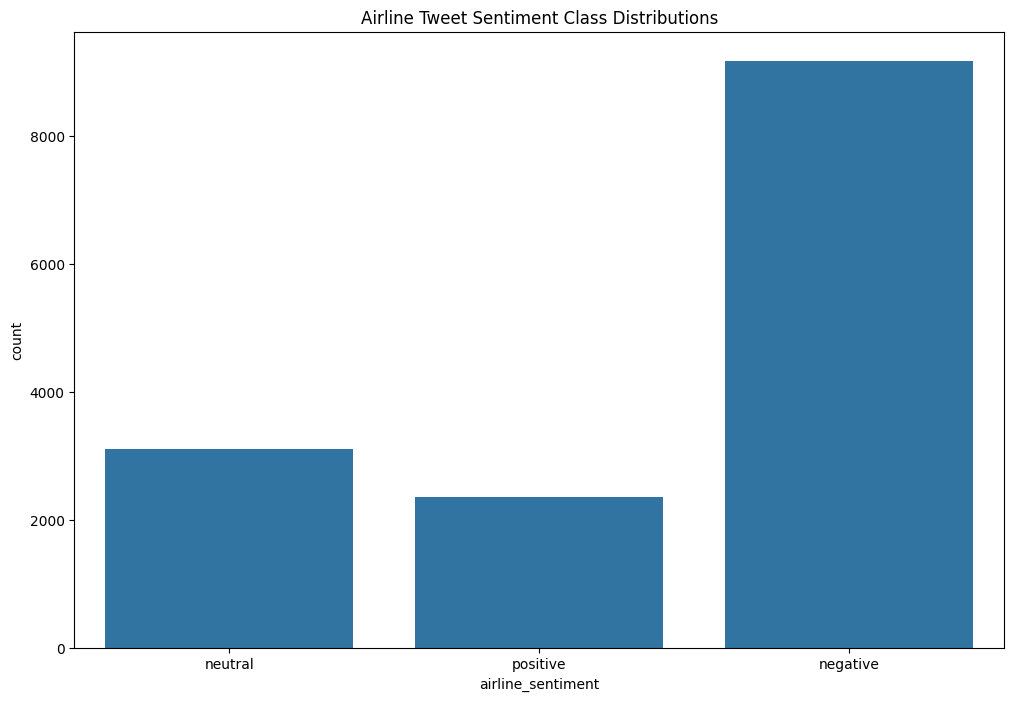

In [14]:
## lets plot this above
fig = plt.figure(figsize=(12,8))
sns.countplot(x='airline_sentiment',data=df).set(title="Airline Tweet Sentiment Class Distributions")
plt.ylabel('count')
plt.show();

In [17]:
## let's see the class distribution in percentages
sent_classes = df['airline_sentiment'].value_counts(normalize=True)*100
print(round(sent_classes,2))

airline_sentiment
negative    62.69
neutral     21.17
positive    16.14
Name: proportion, dtype: float64


Summary:
* We can see the Tweets are dominated by "negative" sentiment.
* With any class imbalance in the target class we need to consider if we should perform up or down sampling or any other techniques to remove class imbalance as it can effect the machine learning model's ability to predict and can cause overfitting in the data.
* However, in this notebook we will not focus on that aspect and instead go with the raw data to see what our predictions are.

## Text Cleaning

In [24]:
## define a function to clean the text
def text_cleaner(text):

  # remove twitter user mentions
  text = re.sub(r'@[A-Za-z0-9]+','', text)

  # remove hashtags - if you want to
  #text = re.sub(r'#[A-Za-z0-9]+','', text)

  # convert text to lowercase
  text = text.lower()

  # fetch only words
  text = re.sub("[^a-z]+", " ", text)

  # remove extra spaces
  text = re.sub("[\s]+", " ", text)

  # create spacy doc object
  doc = nlp(text)

  # remove stopwords and lemmatize text to root words
  tokens = [token.lemma_ for token in doc if(token.is_stop==False)]

  # join tokens by space
  return " ".join(tokens)

In [27]:
## lets apply the text cleaning function
df['clean_text'] = df['text'].apply(text_cleaner)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [28]:
# now save text and labels to a variable
text = df['clean_text'].values

# create class labels
labels = df['airline_sentiment'].values

In [29]:
# sample the cleaned text
text[:10]

array(['  said', '  plus ve added commercials experience tacky',
       '  didn t today mean need trip',
       '  s aggressive blast obnoxious entertainment guests faces amp little recourse',
       '  s big bad thing',
       '  seriously pay flight seats didn t playing s bad thing flying va',
       '  yes nearly time fly vx ear worm won t away',
       '  missed prime opportunity men hats parody https t co mwpg grezp',
       '  didn t d', '  amazing arrived hour early good'], dtype=object)

In [32]:
# text shape
text.shape

(14640,)

In [30]:
# sample the class labels
labels[:10]

array(['neutral', 'positive', 'neutral', 'negative', 'negative',
       'negative', 'positive', 'neutral', 'positive', 'positive'],
      dtype=object)

In [31]:
labels.shape

(14640,)

## Data Preprocessing


### Label Encoding
* Convert labels to numbers

In [33]:
# import label encoder
from sklearn.preprocessing import LabelEncoder

# define label encoder
le = LabelEncoder()

# fit and transform target strings to numbers
labels = le.fit_transform(labels)

In [35]:
# sample labels
labels[:5]

array([1, 2, 1, 0, 0])

In [36]:
# inverse-transform to get meaning of labels
le.inverse_transform([0,1,2])

array(['negative', 'neutral', 'positive'], dtype=object)

Summary:
* We can see the labels stand for the following:
  * 0 - negative
  * 1 - neutral
  * 2 - positive

### Split Data
* Split data into train/test split for building machine learning models.
* X = text input
* y = multiclass sentiment labels
* stratify to the labels for prediction
* test_size will be 80/20 split for train/val or train/test
* We want to shuffle the data during training only (not on test or validation set).

In [37]:
# import train_test_split
from sklearn.model_selection import train_test_split

# split into train and val datasets
X_train, X_val, y_train, y_val = train_test_split(text, labels, stratify=labels, test_size=0.2, random_state=42, shuffle=True)

In [38]:
# check shape of train/val datasets
print(f"Shape of X_train set: {X_train.shape}")
print()
print(f"Shape of y_train set: {y_train.shape}")
print()
print(f"Shape of X_val set: {X_val.shape}")
print()
print(f"Shape of y_val set: {y_val.shape}")

Shape of X_train set: (11712,)

Shape of y_train set: (11712,)

Shape of X_val set: (2928,)

Shape of y_val set: (2928,)


## Feature Engineering with TF-IDF
* This is the "classical NLP" way to do this. It is still quite effective.
* However, a more modern approach would be to use embeddings such as SentenceTransformers which are better at capturing "attention" and context.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
# initialize TFIDF
word_vectorizer = TfidfVectorizer(max_features=1000)

In [41]:
# fit vectorizer on Train data set
word_vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000)

In [42]:
# create TF-IDF vectors for Train set
train_word_features = word_vectorizer.transform(X_train)
train_word_features

<11712x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 67889 stored elements in Compressed Sparse Row format>

In [43]:
# create TF-IDF vectors for Validation dataset
val_word_features = word_vectorizer.transform(X_val)
val_word_features

<2928x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 16698 stored elements in Compressed Sparse Row format>

Summary:
* We can see 1000 features which is based on the max_features we set for the TfidfVectorizer.
* We can also see the number of vectors that were created for train set (11,712) and val set (2,928).

## Machine Learning Model Building

### Naive Bayes Classifier
* We will use the Multinomial Naive Bayes model.
   * This type of Naïve Bayes classifier assumes that the features are from **multinomial distributions.**
   * This variant is useful when using discrete data, such as frequency counts, and it is typically applied within NLP use cases, like spam classification.
   * The multinomial distribution is a generalization of the binomial distribution to the case of n repeated trials where there are more than two possible outcomes to each.
     * The multinomial distribution also is most commonly used with categorical data which we encode as numbers (in our case here sentiment analysis with 0, 1, 2.)
* The 2 other commonly used Naive Bayes classifiers are:
   * **Gaussian** - assumes a normal or Gaussian distribution and continuous variables.
   * **Bernoulli** - typicall uses boolean values or binary variables 0 or 1.

In [44]:
## imports for modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

In [46]:
# Train the model
nb_model = MultinomialNB().fit(train_word_features, y_train)
nb_model

MultinomialNB()

In [47]:
# make predictions on the train data
train_pred_nb = nb_model.predict(train_word_features)

In [48]:
# print predictions
train_pred_nb

array([0, 1, 0, ..., 0, 0, 1])

In [54]:
# evaluate results on train set - in sample evaluation
print(f"The F1 score on training set is: {f1_score(y_train, train_pred_nb, average='weighted'):2f}")

The F1 score on training set is: 0.734337


In [55]:
## now make predictions on validation set - out of sample evaluation
val_pred_nb = nb_model.predict(val_word_features)

# evaluate on Validation set
print(f"The F1 score on Validation set: {f1_score(y_val, val_pred_nb, average='weighted'):2f}")

The F1 score on Validation set: 0.707656


Summary:
* We can see the F1 score is ~71% on the validation set for the Multinomial Naive Bayes Classifier.
* Let's see if a Logistic Regression model can perform better.

### Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [61]:
#train model
log_reg_model = LogisticRegression().fit(train_word_features, y_train)
log_reg_model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

How does logistic regression model work on multiclass classification?
* Works on theory of "one versus all" converts multiple classes into binary classification problem.

In [62]:
# make preds on train set
train_pred_lr = log_reg_model.predict(train_word_features)
train_pred_nb

array([0, 1, 0, ..., 0, 0, 1])

In [63]:
# eval on train set - in sample prediction
print(f"The F1 score on Logistic Regression train set: {f1_score(y_train, train_pred_lr, average='weighted'):2f}")

The F1 score on Logistic Regression train set: 0.799480


In [64]:
# eval on validation set - out of sample prediction
val_pred_lr = log_reg_model.predict(val_word_features)

# eval on Validation Set
print(f"The F1 score on Logistic Regression validation set: {f1_score(y_val, val_pred_lr, average='weighted'):2f}")

The F1 score on Logistic Regression validation set: 0.746187


## Summary of Models

Model           Train vs. Validation Sets
1. Naive Bayes: 0.7343 | 0.7076
2. Logistic Reg: 0.799 | 0.746


We can see that Logistic Regression performed better than Naive Bayes on both training and validation datasets.

# Final Sentiment Analysis Pipeline
* We will use the better performing model on our data, the Logistic Regression model for the final analysis pipeline.

In [76]:
# creating a function to analyze tweets with our model
def sentiment_analyzer(tweet):
  # clean tweet -> apply text_cleaner function
  cleaned_tweet = text_cleaner(tweet)

  # feature engineering - tfidf vectorize cleaned tweet
  tweet_vector = word_vectorizer.transform([cleaned_tweet])

  # predict sentiment - with best model logistic regression
  label = log_reg_model.predict(tweet_vector)

  # return result - array with labels
  return le.inverse_transform(np.array(label))

In [77]:
## columns
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'clean_text'],
      dtype='object')

In [98]:
## get a sample tweet to test with pipeline
import random
rand_tweet = df.sample(1)['text']
rand_tweet

758    @united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 737's are not too big... Not too small!
Name: text, dtype: object

In [101]:
## test out the sentiment_analyzer
sentiment_analyzer("@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 737's are not too big... Not too small!")

array(['positive'], dtype=object)